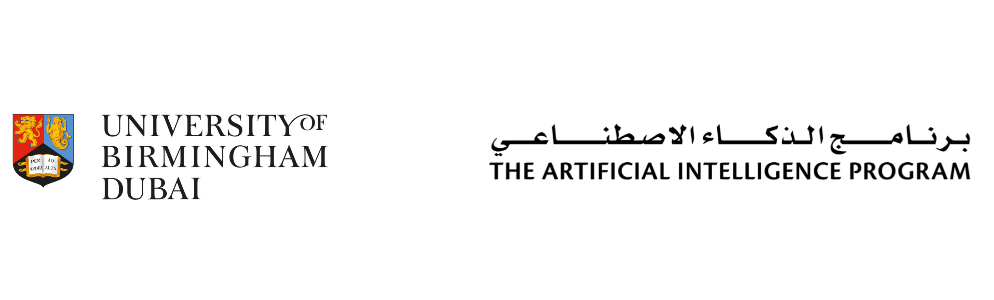

# Hands-On Exercise: Convolutional Neural Networks

CNNs are a powerful type of deep learning model specifically designed to process and understand visual data. In this lesson, we'll explore how CNNs can be trained to automatically detect defects in images of objects—quickly, accurately, and at scale.

## Fix Seed!

In [ ]:
import random
import numpy as np
import torch

# Fix the seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Download Dataset!

In [ ]:
!gdown https://drive.google.com/uc?id=1bfSlfbyGZmWCzVXffVqhGu0HNyI46HOG -O zipped_files.zip
!unzip -q zipped_files.zip

## Creating Dataset!

You can just run this line!

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split, StratifiedKFold

class DefectDataset(Dataset):
    """
    Loads images and defect labels from a CSV file for training a model.
    """

    def __init__(self, csv_file="downloadable_data/labels.csv", img_folder="downloadable_data/data", INPUT_IMG_SIZE=(224, 224)):
        # Read the CSV file with image names and labels
        self.data = pd.read_csv(csv_file)
        self.img_folder = img_folder

        # Set how images should be resized and converted into tensors
        self.transform = transforms.Compose([
            transforms.Resize(INPUT_IMG_SIZE),
            transforms.ToTensor(),
        ])

        # Create full image paths by joining folder name and file names
        self.img_paths = self.data['filename'].apply(lambda x: os.path.join(img_folder, x)).tolist()

        # Convert text labels into 0 (no defect) or 1 (defect)
        self.labels = self.data['class'].apply(lambda x: 0 if x == 'no defect' else 1).tolist()

        # Keep extra detailed labels in case we need them later
        self.detailed_labels = self.data['detailed_class'].tolist()

    def __len__(self):
        # Returns how many items (images) are in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Loads one image and its label using the index
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")  # Make sure image is in color
        img = self.transform(img)  # Resize and convert to tensor

        return img, torch.tensor(label, dtype=torch.long)

### 🚨🚨🚨 **Exercise 1** 🚨🚨🚨

Play around with the DefectDataset class!

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Instantiate the dataset
dataset = DefectDataset()

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO:  Print the length of the dataset (hint: treat the dataset variable like a list of items) -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
length = None
print(f"Total samples in dataset: {length}\n")


# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO: Access the first item in the dataset (hint: treat the dataset variable like a list of items) -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
img, label = None
print("First image shape:", img.shape)
print("First image label (binary):", label.item())

# Convert image tensor to NumPy format for display
img_np = img.permute(1, 2, 0).numpy()  # from (C, H, W) to (H, W, C)
# Plot the image
plt.imshow(img_np)
plt.title(f"Label: {'Defect' if label.item() else 'No Defect'}")
plt.axis('off')
plt.show()

## Dataloaders (How We Access Our Data)

You can just run this line!

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = DefectDataset()

# Get list of all data indices (like 0, 1, 2, ..., len-1)
indices = list(range(len(dataset)))

# Get detailed labels (used for stratified splitting because our data is imbalanced)
stratify_labels = dataset.detailed_labels

# Settings for splitting
test_size = 0.20  # 20% for test set
random_state = 42  # to make the split reproducible

# First split: split dataset into train and test, keeping label distribution similar
train_idx, test_idx = train_test_split(
    indices,
    test_size=test_size,
    stratify=stratify_labels,
    random_state=random_state,
)

# Get labels from training set only (needed for second stratified split because our data is imbalanced)
train_stratify_labels = [stratify_labels[i] for i in train_idx]

# Second split: split training data into final train and validation
train_idx_final, val_idx = train_test_split(
    train_idx,
    test_size=0.25,  # 25% of train becomes validation → 60% train, 20% val, 20% test
    stratify=train_stratify_labels,
    random_state=random_state,
)

# Create samplers to pick the right subset of data
train_sampler = SubsetRandomSampler(train_idx_final)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Create DataLoaders to load data in batches
train_loader = DataLoader(dataset, batch_size=10, sampler=train_sampler, drop_last=True)

### 🚨🚨🚨 **Exercise 2** 🚨🚨🚨

Explore how DataLoaders are declared and used to iterate through the sampled dataset.

In [ ]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO: Define the Validation and Test Dataloaders using 'dataset' and the samplers created with batch size of 10. -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# (Hint: refer to how we declared the train_loader variable)
val_loader = None
test_loader = None

import matplotlib.pyplot as plt

print("Iterating through the test DataLoader...")

# Loop through batches in the test DataLoader
for batch_imgs, batch_labels in test_loader:
    # Print batch number and shapes of inputs and labels
    print("First Batch")
    print(f"x (images) shape: {batch_imgs.shape}")
    print(f"y (labels) shape: {batch_labels.shape}")

    # Displaying the images of the first batch (you can ignore what follows):
    batch_size = batch_imgs.size(0) # Set up grid layout for displaying images
    cols = 5
    rows = (batch_size + cols - 1) // cols  # Calculate number of rows needed

    print("Displaying the first batch of images:")
    plt.figure(figsize=(15, 6))
    for i in range(batch_size):
        # Rearrange image tensor from [C, H, W] to [H, W, C] for plotting
        img = batch_imgs[i].permute(1, 2, 0).numpy()
        label = 'Defect' if batch_labels[i].item() == 1 else 'No Defect'

        # Plot the image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    break

## Models

You can just run this line!

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class CustomResNet18(nn.Module):
    """
    A custom image classifier built on top of ResNet18.
    It uses ResNet18's pretrained feature extractor and adds a small custom head for classification.
    We also freeze some of the early layers so the model doesn't have to relearn basic visual features.
    """

    def __init__(self, n_classes=2, freeze_until='layer3'):
        super(CustomResNet18, self).__init__()

        # Load a ResNet18 model that already learned from a large image dataset
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Take all layers except the final average pooling and fully connected (classification) layers
        self.backbone = nn.Sequential(*list(base_model.children())[:-2])

        # Freeze the early layers so we don't train them again
        self._freeze_layers(base_model, freeze_until=freeze_until)

        # Add our own small classification "head" on top
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),     # Squeeze each feature map down to 1 value (global average)
            nn.Flatten(),                     # Flatten the output into a vector
            nn.Linear(in_features=512, out_features=n_classes),  # Final layer to predict class scores
        )

    def _freeze_layers(self, model, freeze_until='layer3'):
        """
        Turn off training (freeze) for all layers up to and including the given point.
        This lets the model keep its low-level vision knowledge without changing it.
        """
        freezing = True
        for name, child in model.named_children():
            if name == 'fc' or name == 'avgpool':  # Skip these since we're replacing them
                continue
            for param in child.parameters():
                param.requires_grad = not freezing  # Stop or start training based on the flag
            if name == freeze_until:
                freezing = False  # After this layer, we start training again

    def forward(self, x):
        # Pass input through the pretrained layers to get image features
        features = self.backbone(x)

        # Pass features through our custom head to get class scores
        scores = self.classification_head(features)

        if self.training:
            return scores  # During training, just return the raw scores
        else:
            probs = nn.functional.softmax(scores, dim=-1)  # During inference, convert to probabilities
            return probs, features

### 🚨🚨🚨 **Exercise 3** 🚨🚨🚨:

Declare our custom model based on the class we have defined and explore how you can pass in input images into our custom model.

In [ ]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO: Declare the model using the class above -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
model = None

# Set to evaluation mode
model.eval()

# Generate 4 fake images (3 color channels, 224x224)
dummy_input = torch.randn(4, 3, 224, 224)

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO: Pass the dummy_input into the model object -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
probs, features = None

# Printing outputs
print("Probabilities:", probs)
print("Shape of output probabilities:", probs.shape)
print("Shape of extracted features:", features.shape)

## Time to Fine Tune!

You can just run this cell!

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

def train_CNN(model, epochs, lr, train_loader, val_loader, class_weight=[1, 3], patience=2):
    """
    Trains a CNN model with early stopping.

    Args:
        model (torch.nn.Module): The CNN model to train
        epochs (int): Number of training epochs
        lr (float): Learning rate
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        class_weight (list): Class weights for handling class imbalance
        patience (int): Early stopping patience
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    class_weight_tensor = torch.tensor(class_weight, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    no_improve_count = 0

    for epoch in range(1, epochs + 1):
        model.train()
        cumulative_training_loss = 0.0
        cumulative_correct = 0
        cumulative_n_samples = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds_scores = model(inputs)
            preds_class = torch.argmax(preds_scores, dim=-1)
            loss = criterion(preds_scores, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            cumulative_training_loss += loss.item() * batch_size
            cumulative_correct += (preds_class == labels).sum().item()
            cumulative_n_samples += batch_size

        epoch_loss = cumulative_training_loss / cumulative_n_samples
        epoch_acc = cumulative_correct / cumulative_n_samples
        tqdm.write(f"Training Loss = {epoch_loss:.4f}, Training Accuracy = {epoch_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                preds_scores, _ = model(inputs)
                preds_class = torch.argmax(preds_scores, dim=-1)
                loss = criterion(preds_scores, labels)

                batch_size = inputs.size(0)
                val_loss += loss.item() * batch_size
                val_correct += (preds_class == labels).sum().item()
                val_samples += batch_size

        val_loss /= val_samples
        val_acc = val_correct / val_samples
        tqdm.write(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.4f}")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve_count = 0
        else:
            no_improve_count += 1
            tqdm.write(f"Validation did not improve for {no_improve_count} consecutive epochs.")

        if no_improve_count >= patience:
            tqdm.write("Early stopping due to no improvement in validation accuracy.")
            break


### 🚨🚨🚨 **Exercise 4** 🚨🚨🚨:

Let's train the model using the ```train_CNN``` function we have declared above!

In [ ]:
model = CustomResNet18()

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO: Call the function to train the CNN, passing in the correct variables  -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Use 10 epochs and a learning rate of 0.0001
train_CNN(model=None, epochs=None, lr=None, train_loader=None, val_loader=None)

## Let's evaluate the trained model!

You can just run this cell!

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

def evaluate_CNN(model, test_loader, class_names=['Good', 'Defect']):
    """
    Evaluates a trained CNN on the test set and prints performance metrics.

    Args:
        model (nn.Module): Trained CNN model
        test_loader (DataLoader): Test set DataLoader
        class_names (list): List of class labels (default: ['Good', 'Defect'])
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_score = []  # For AUROC (probability of positive class)

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=True):
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds_probs, _ = model(inputs)  # Assumes model returns (probs, features)
            preds_class = torch.argmax(preds_probs, dim=-1)

            labels = labels.cpu().numpy()
            preds_class = preds_class.cpu().numpy()

            y_true.extend(labels.tolist())
            y_pred.extend(preds_class.tolist())
            y_score.extend(preds_probs[:, 1].cpu().tolist())  # Probability of class 1

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_score)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    # Log results
    tqdm.write("Evaluation Results:")
    tqdm.write(f"Accuracy: {accuracy:.4f}")
    tqdm.write(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    tqdm.write(f"AUROC: {auroc:.4f}")
    tqdm.write("\nClassification Report:\n" + report)

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

def plot_confusion_matrix(y_true, y_pred, class_names="auto"):
    confusion = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confusion,
        annot=True,
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues",
        fmt="d"
    )
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


### 🚨🚨🚨 **Exercise 5** 🚨🚨🚨:

Let's evaluate our fine tuned model using the above ```evaluate_CNN``` function.

In [ ]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= TO DO: Call the function to train the CNN, passing in the correct variables  -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
evaluate_CNN(model=None, test_loader=None)

## What is happening inside?

You can just run these cells and look at the visualizations that are produced! This is what the CNN is "seeing"!

In [ ]:
!pip install grad-cam

In [ ]:
from torchvision.transforms.functional import to_pil_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import deprocess_image
import matplotlib.pyplot as plt
import numpy as np
import os

def generate_gradcam_for_defects(dataloader, set_name="test", max_display=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    displayed = 0

    # Setup: hook into last convolutional layer of the model
    target_layer = model.backbone[-1]  # last layer of backbone
    cam = GradCAM(model=model, target_layers=[target_layer])

    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc=f"Generating Grad-CAM for {set_name}")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        preds_probs, _ = model(inputs)
        preds_class = torch.argmax(preds_probs, dim=-1)

        for i in range(inputs.size(0)):
            label = labels[i].item()
            pred = preds_class[i].item()

            if label == 1:  # Only show actual defects
                input_img = inputs[i].unsqueeze(0)
                target_category = pred

                # Get Grad-CAM
                grayscale_cam = cam(input_tensor=input_img, targets=[ClassifierOutputTarget(target_category)])
                grayscale_cam = grayscale_cam[0, :]

                # Prepare images
                rgb_img = input_img.squeeze().detach().cpu()
                rgb_img = rgb_img.permute(1, 2, 0).numpy()
                rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)

                cam_overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                # Determine correctness
                status = "Correct" if pred == label else "Incorrect"

                # Plot original and Grad-CAM side-by-side
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(rgb_img)
                axs[0].set_title("Original Image")
                axs[0].axis("off")

                axs[1].imshow(cam_overlay)
                axs[1].set_title(f"Prediction: {status}")
                axs[1].axis("off")

                plt.tight_layout()
                plt.show()

                displayed += 1
                if displayed >= max_display:
                    return

generate_gradcam_for_defects(test_loader, set_name="test", max_display=15)